In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv(r"E:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\Dataset\Outcome\full_battery_data.csv")

# Normalize SOC if it's 0–100
if df["SOC"].max() > 1.0:
    df["SOC"] = df["SOC"] / 100.0

# Add Power column
df["Power"] = df["Voltage"] * df["Current"]


In [3]:
def create_knn_sequences(data, window_size=100, step=10):
    X, y = [], []
    features = ['Voltage', 'Current', 'Temperature', 'Power']
    for i in range(0, len(data) - window_size, step):
        window = data[i:i+window_size][features].values.flatten()
        target = data.iloc[i + window_size]['SOC']
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

X_all, y_all = [], []

# Apply to all drive cycle & temperature combinations
for (temp, cycle), group in df.groupby(['TemperatureLabel', 'DriveCycle']):
    group = group.reset_index(drop=True)
    X, y = create_knn_sequences(group)
    X_all.append(X)
    y_all.append(y)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [5]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=-1)
knn_model.fit(X_train, y_train)


KNeighborsRegressor(n_jobs=-1, weights='distance')

In [6]:
y_pred = knn_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R²:   {r2:.5f}")


MAE:  0.07611
RMSE: 0.11687
R²:   0.80451


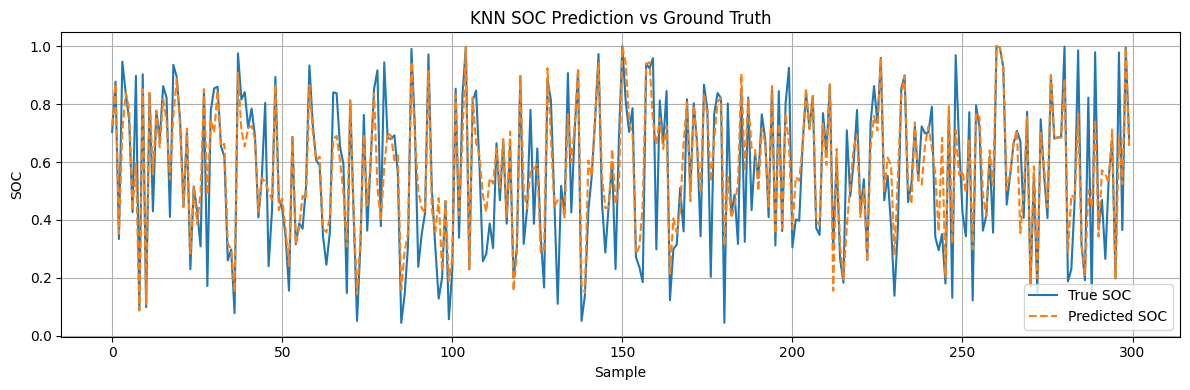

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(y_test[:300], label="True SOC")
plt.plot(y_pred[:300], label="Predicted SOC", linestyle='--')
plt.title("KNN SOC Prediction vs Ground Truth")
plt.xlabel("Sample")
plt.ylabel("SOC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


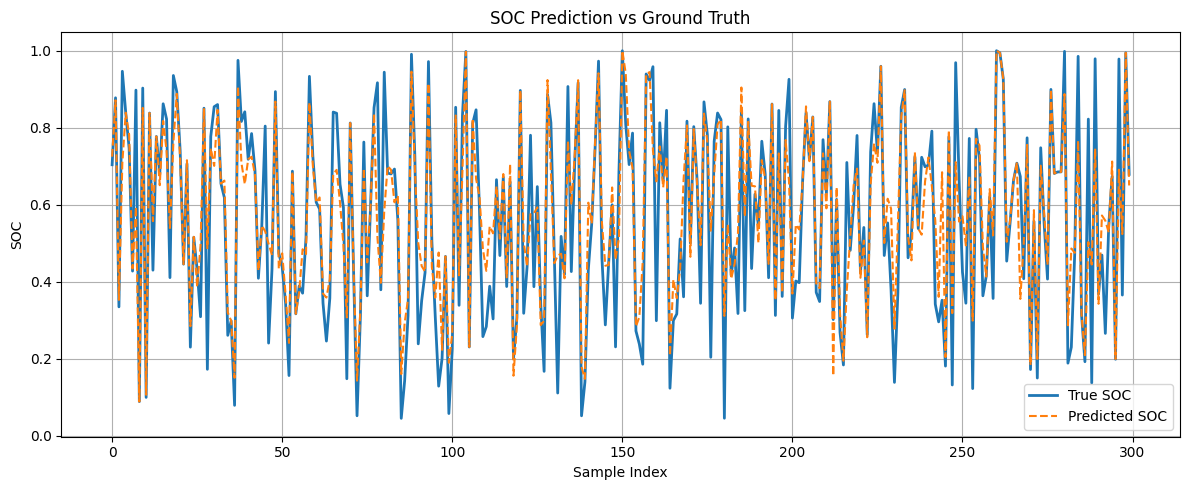

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test[:300], label='True SOC', linewidth=2)
plt.plot(y_pred[:300], label='Predicted SOC', linestyle='--')
plt.title("SOC Prediction vs Ground Truth")
plt.xlabel("Sample Index")
plt.ylabel("SOC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


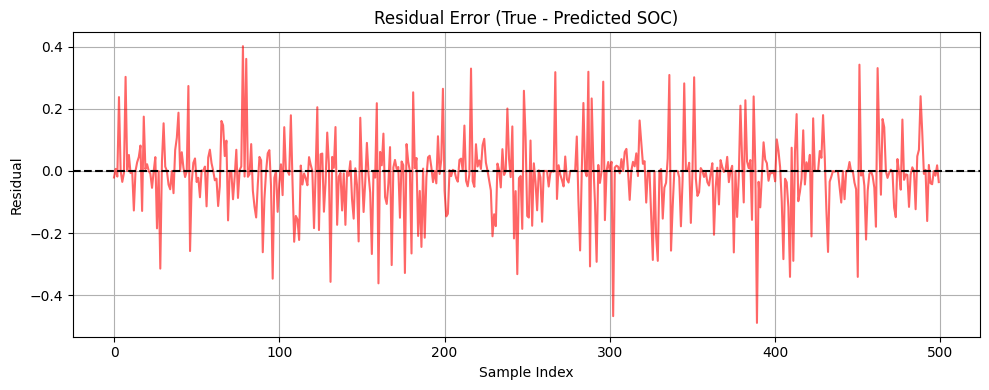

In [9]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 4))
plt.plot(residuals[:500], color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual Error (True - Predicted SOC)")
plt.xlabel("Sample Index")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()


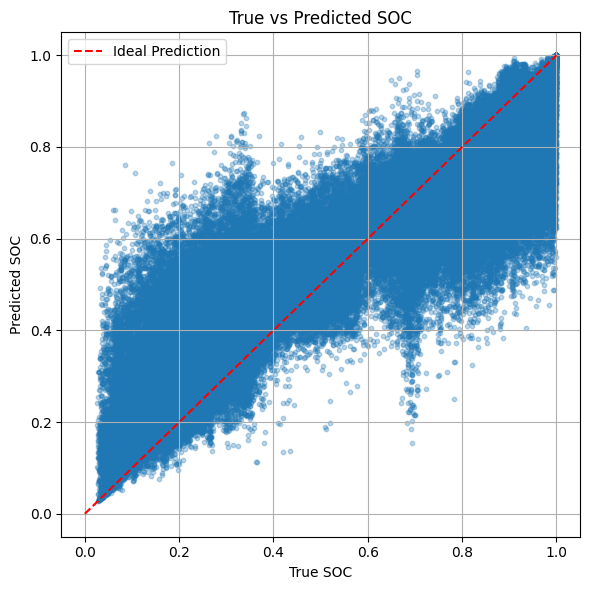

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal Prediction')
plt.xlabel("True SOC")
plt.ylabel("Predicted SOC")
plt.title("True vs Predicted SOC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
